<center><img src="images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 1, Lab 3: Building an End-to-End Neural Network Solution

In the previous lab, you used a neural network with image data to predict the category that an item belonged to. In this lab, you will process text data by building an end-to-end neural network solution. The solution will incorporate all the data processing techniques that you have learned so far. 

You will learn how to do the following:

- Import and preprocess data.
- Create a neural network with multiple layers.
- Train text data with your neural network.
- Validate your model as you train.
- Change different parameters to improve your neural network.

---

__Austin Animal Center Dataset__

In this lab, you will work with historical pet adoption data in the [Austin Animal Center Shelter Intakes and Outcomes dataset](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes?resource=download). The target field of the dataset (**Outcome Type**) is the outcome of adoption: 1 for adopted and 0 for not adopted. Multiple features are used in the dataset.

Dataset schema:
- __Pet ID:__ Unique ID of the pet
- __Outcome Type:__ State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome:__ Sex of pet at outcome
- __Name:__ Name of pet 
- __Found Location:__ Found location of pet before it entered the shelter
- __Intake Type:__ Circumstances that brought the pet to the shelter
- __Intake Condition:__ Health condition of the pet when it entered the shelter
- __Pet Type:__ Type of pet
- __Sex upon Intake:__ Sex of pet when it entered the shelter
- __Breed:__ Breed of pet 
- __Color:__ Color of pet 
- __Age upon Intake Days:__ Age (days) of pet when it entered the shelter
- __Age upon Outcome Days:__ Age (days) of pet at outcome

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |


---
## Index

* [Data processing](#Data-processing)
* [Training and validation of a neural network](#Training-and-validation-of-a-neural-network)
* [Testing the neural network](#Testing-the-neural-network)
* [Improvement ideas](#Improvement-ideas)

---
## Data processing

The first step is to process the dataset.

In [2]:
# Install libraries
!pip install -U -q -r requirements.txt
!pip uninstall -y autovizwidget hdijupyterutils sparkmagic
!pip install autovizwidget==0.21.0 hdijupyterutils==0.21.0 sparkmagic==0.21.0



Found existing installation: autovizwidget 0.21.0
Uninstalling autovizwidget-0.21.0:
  Successfully uninstalled autovizwidget-0.21.0
Found existing installation: hdijupyterutils 0.21.0
Uninstalling hdijupyterutils-0.21.0:
  Successfully uninstalled hdijupyterutils-0.21.0
Found existing installation: sparkmagic 0.21.0
Uninstalling sparkmagic-0.21.0:
  Successfully uninstalled sparkmagic-0.21.0
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.3 MB/s eta 0:00:0000:0100:01
  Created wheel for autovizwidget: filename=autovizwidget-0.21.0-py3-none-any.whl size=14670 sha256=697cf995cf2e74414901a3dd263e4e2fc9a569767f9f7fe3e2fa35a08fe9630f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/89/a4/8b/8031ab10b516319e98fd9a555a49bd8ae3d3de4c8584ba4626
  Created wheel for hdijupyte

In [3]:
# Import the dependencies
import boto3
import os
from os import path
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re, string
import nltk
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
import torch
from torch import nn

from MLUDTI_M1_Lab3_neural_network import NeuralNetwork

First, read the dataset into a DataFrame and look at it. The data might look familiar because it was used in the labs of the Machine Learning through Application course.

In [4]:
df = pd.read_csv("data/austin-animal-center-dataset.csv")

print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (95485, 13)


In [5]:
# Print the first five rows of the dataset
df.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,A794011,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730,730
1,A776359,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365,365
2,A674754,0.0,Intact Male,NaN,12034 Research in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,Orange Tabby,6,6
3,A689724,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60,60
4,A680969,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7,60


### EDA

Now, perform the basic steps of exploratory data analysis (EDA) and look for insights to inform later ML modeling choices.

In [6]:
# Print the data types and nonnull values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [7]:
# Print the column names
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


In [8]:
# Create lists that identify the numerical, categorical, and text features, and the target/label
numerical_features = ["Age upon Intake Days", "Age upon Outcome Days"]

categorical_features = [
    "Sex upon Outcome",
    "Intake Type",
    "Intake Condition",
    "Pet Type",
    "Sex upon Intake",
]

text_features = ["Found Location", "Breed", "Color"]

model_features = numerical_features + categorical_features + text_features
model_target = "Outcome Type"

__Note__: The **Pet ID** and **Name** features were omitted because they are irrelevant to the outcome.

### Cleaning the data

#### Cleaning numerical features

Take a moment to examine the numerical features. Remember that the `value_counts()` function can give a view of the numerical features by placing feature values in respective bins. The function can also be used for plotting.

Age upon Intake Days
(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Intake Days, dtype: int64


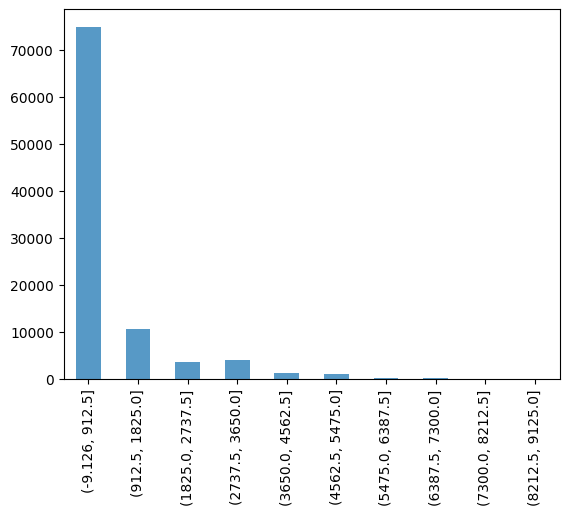

Age upon Outcome Days
(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Outcome Days, dtype: int64


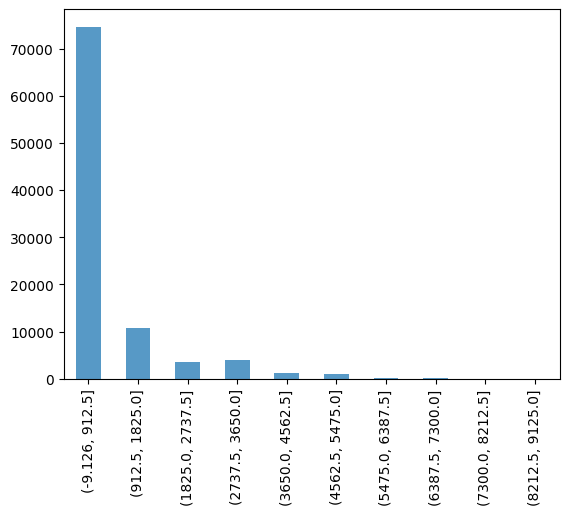

In [9]:
for c in numerical_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    df[c].value_counts(bins=10, sort=False).plot(kind="bar", alpha=0.75, rot=90)
    plt.show()

If any outliers are identified as likely wrong values, dropping them could improve the histograms for the numerical values and could later improve overall model performance.

Remove any values in the upper 10 percent for the feature, and then plot the features.

In [10]:
for c in numerical_features:
    # Drop values beyond 90% of max()
    dropIndexes = df[df[c] > df[c].max() * 9 / 10].index
    df.drop(dropIndexes, inplace=True)

Age upon Intake Days
(-6.936, 693.5]     61425
(693.5, 1387.0]     18400
(1387.0, 2080.5]     5657
(2080.5, 2774.0]     3471
(2774.0, 3467.5]     2557
(3467.5, 4161.0]     1962
(4161.0, 4854.5]     1148
(4854.5, 5548.0]      596
(5548.0, 6241.5]      183
(6241.5, 6935.0]       63
Name: Age upon Intake Days, dtype: int64


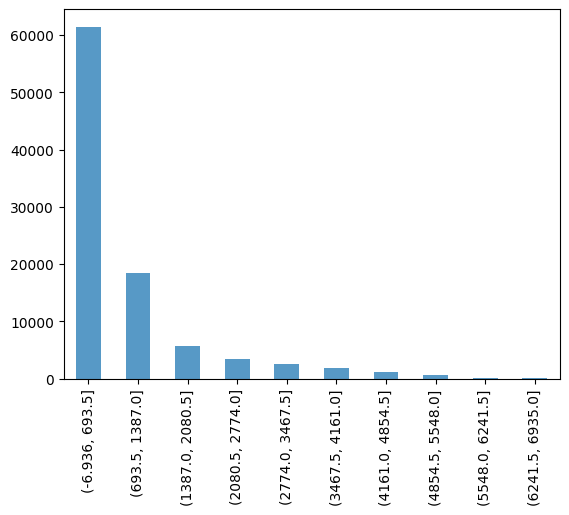

Age upon Outcome Days
(-6.936, 693.5]     61208
(693.5, 1387.0]     18490
(1387.0, 2080.5]     5643
(2080.5, 2774.0]     3465
(2774.0, 3467.5]     2600
(3467.5, 4161.0]     2004
(4161.0, 4854.5]     1196
(4854.5, 5548.0]      604
(5548.0, 6241.5]      187
(6241.5, 6935.0]       65
Name: Age upon Outcome Days, dtype: int64


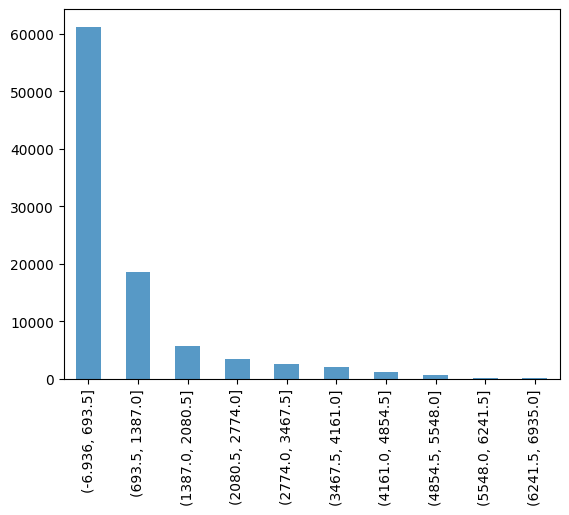

In [11]:
for c in numerical_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    df[c].value_counts(bins=10, sort=False).plot(kind="bar", alpha=0.75, rot=90)
    plt.show()

#### Cleaning text features

Take a moment to examine the text features.

In [12]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and", "in"]

stemmer = SnowballStemmer("english")


def preProcessText(text):
    # Lowercase text, and strip leading and trailing white space
    text = text.lower().strip()

    # Remove HTML tags
    text = re.compile("<.*?>").sub("", text)

    # Remove punctuation
    text = re.compile("[%s]" % re.escape(string.punctuation)).sub(" ", text)

    # Remove extra white space
    text = re.sub("\s+", " ", text)

    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

__Note:__ The text cleaning process can take a while to complete, depending on the size of the text data.

In [13]:
# Clean the text features
for c in text_features:
    print("Text cleaning: ", c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Found Location
Text cleaning:  Breed
Text cleaning:  Color


### Train, validation, and test datasets

Now that the data has been cleaned, you need to split the full dataset into training and test subsets by using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. With this function, you can specify the following:

- The proportion of the dataset to include in the test split as a number between 0.0-1.0 with a default of 0.25.
- An integer that controls the shuffling that is applied to the data before the split. Passing an integer allows for reproducible output across multiple function calls.

To help reduce sampling bias, the original dataset is shuffled before the split. After the initial split, the training data is further split into training and validation subsets.

In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    df, test_size=0.15, shuffle=True, random_state=23
)

train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the training, validation, and test datasets
print(
    "Train - Validation - Test dataset shapes: ",
    train_data.shape,
    val_data.shape,
    test_data.shape,
)

Train - Validation - Test dataset shapes:  (68970, 13) (12172, 13) (14320, 13)


### Data processing with a pipeline and ColumnTransformer

In a typical ML workflow, you need to apply data transformations, such as imputation and scaling, at least twice: first on the training dataset by using `.fit()` and `.transform()` when preparing the data to train the model, and then by using `.transform()` on any new data that you want to predict on (validation or test). Sklearn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is a tool that simplifies this process by enforcing the implementation and order of data processing steps.

In this section, you will build separate pipelines to handle the numerical, categorical, and text features. Then, you will combine them into a composite pipeline along with an estimator. To do this, you will use a [LogisticRegression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

You will need multiple pipelines to ensure that all the data is handled correctly:

   * __Numerical features pipeline:__  Impute missing values with the mean by using sklearn's `SimpleImputer`, followed by `MinMaxScaler`. If different processing is desired for different numerical features, different pipelines should be built as described for the text features pipeline.

   * __Categoricals pipeline:__ Impute with a placeholder value (this won't have an effect because you already encoded the `nan` values), and encode with sklearn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check the number of unique values for the categoricals to get an estimate of how many dummy features one-hot encoding will create. Note the `handle_unknown` parameter, which tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation or test set that was not present in the initial training set.

   * __Text features pipeline:__ With memory usage in mind, build three more pipelines, one for each of the text features. The current sklearn implementation requires a separate transformer for each text feature (unlike the numericals and categoricals).


Finally, the selective preparations of the dataset features are then put together into a collective ColumnTransformer, which is used in a pipeline along with an estimator. This ensures that the transforms are performed automatically in all situations. This includes on the raw data when fitting the model, when making predictions, when evaluating the model on a validation dataset through cross-validation, or when making predictions on a test dataset in the future.

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline(
    [
        ("num_imputer", SimpleImputer(strategy="mean")),
        (
            "num_scaler",
            MinMaxScaler(),
        ),  
    ]
)

# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        (
            "cat_imputer",
            SimpleImputer(strategy="constant", fill_value="missing"),
        ),  # Shown in case it is needed. No effect here because you already imputed with 'nan' strings.
        (
            "cat_encoder",
            OneHotEncoder(handle_unknown="ignore"),
        ),  # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
    ]
)

# Preprocess first text feature
text_processor_0 = Pipeline(
    [("text_vectorizer_0", CountVectorizer(binary=True, max_features=50))]
)

# Preprocess second text feature
text_processor_1 = Pipeline(
    [("text_vectorizer_1", CountVectorizer(binary=True, max_features=50))]
)

# Preprocess third text feature
text_processor_2 = Pipeline(
    [("text_vectorizer_2", CountVectorizer(binary=True, max_features=50))]
)

# Combine all data preprocessors (add more if you choose to define more)
# For each processor/step, specify: a name, the actual process, and the features to be processed.
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
        ("text_processing_0", text_processor_0, text_features[0]),
        ("text_processing_1", text_processor_1, text_features[1]),
        ("text_processing_2", text_processor_2, text_features[2]),
    ]
)

# Visualize the data processing pipeline
from sklearn import set_config

set_config(display="diagram")
data_processor

ColumnTransformer(transformers=[('numerical_processing',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 ['Age upon Intake Days',
                                  'Age upon Outcome Days']),
                                ('categorical_processing',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))])...
                                ('text_processing_0',
                                 Pipeline(steps=[('text_vectorizer_0',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'Found Location'),
                                ('text_processing_1',
                                 Pipeline(steps=[('text_vectorizer_1',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'Breed'),
                                ('text_processing_2',
                                 Pipeline(steps=[('text_vectorizer_2',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'Color')])

In [16]:
# Prepare data for training
X_train = train_data[model_features]
y_train = train_data[model_target].values

# Get validation data to validate the network
X_val = val_data[model_features]
y_val = val_data[model_target].values

# Get test data to test the network for submission to the leaderboard
X_test = test_data[model_features]
y_test = test_data[model_target].values

print("Dataset shapes before processing: ", X_train.shape, X_val.shape, X_test.shape)

X_train = data_processor.fit_transform(X_train).toarray()
X_val = data_processor.transform(X_val).toarray()
X_test = data_processor.transform(X_test).toarray()

print("Dataset shapes after processing: ", X_train.shape, X_val.shape, X_test.shape)

Dataset shapes before processing:  (68970, 10) (12172, 10) (14320, 10)
Dataset shapes after processing:  (68970, 171) (12172, 171) (14320, 171)


---
## Training and validation of a neural network

Now, run the following code cell to interact with the neural network to gain insight into how neural networks train.

Architect the neural network by updating the number of layers (maximum of 4) and the number of neurons per layer (maximum of 3) to solve the classification problem that displays when you run the following cell. The background colors show the neural network's predicted classification regions for the true data (circles).

Note that upon retraining the network, the weights are randomly initialized, and the gradients are reset to 0. In the visual representation, each green circle corresponds to an epoch. Each red circle corresponds to that layer's weight update gradient (from backpropagation).

To develop a better understanding, train the model for different architectures. Note that the model gets stuck sometimes—initialization is important!

In [17]:
NeuralNetwork()

Now you need to build a PyTorch neural network and use it to fit to the training data. As part of the training, you need to use the validation data to check performance at the end of each training iteration.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style="text-align: center; margin: auto;">To define the hyperparameters of the algorithm, run the following cell. Note how the data is loaded into PyTorch tensors. Observe how the DataLoader is defined. The DataLoader is used to load the data in batches during training.</p>
    <br>
</div>

In [18]:
# Define the hyperparamaters
batch_size = 16
num_epochs = 15
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert the data into PyTorch tensors

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Use PyTorch DataLoaders to load the data in batches
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           drop_last=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         drop_last=True)

<div style="border: 4px solid coral; text-align: center; margin: auto;"> 
    <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center; margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Create a multilayer perceptron by using the <code>Sequential</code> module with the following attributes: </p> <br>
<p style=" text-align: center; margin: auto;">1. Use two hidden layers, both of size 64.</p>
<p style=" text-align: center; margin: auto;">2. Attach a dropout layer to each hidden layer.</p>
<p style=" text-align: center; margin: auto;">3. Use a ReLU activation for each hidden layer.</p>
<p style=" text-align: center; margin: auto;">4. Create one output layer.</p>
    <br>
</div>

In [21]:
# Create a multilayer perceptron by using the Sequential module. Add the following in sequence:
# Two hidden layers of size 64
# Dropout layers attached to the hidden layers
# ReLU activation functions
# One output layer

############### CODE HERE ###############


# Create a multilayer perceptron
net = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),  # input layer
    nn.ReLU(),  # activation function
    nn.Dropout(0.5),  # dropout layer to prevent overfitting
    nn.Linear(64, 64),  # hidden layer
    nn.ReLU(),  # activation function
    nn.Dropout(0.5),  # dropout layer to prevent overfitting
    nn.Linear(64, len(torch.unique(y_train.cpu())))  # output layer
)

# Display the architecture of the network
print(net)


############## END OF CODE ##############


def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

Sequential(
  (0): Linear(in_features=171, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=2, bias=True)
)


Sequential(
  (0): Linear(in_features=171, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=2, bias=True)
)

In [22]:
# Define the loss function and the optimizer
# Choose cross-entropy loss for this classification problem
loss = nn.CrossEntropyLoss()

# Optimize with stochastic gradient descent. You can experiment with other optimizers.
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To train the network, run the following cell. Watch how the training and validation loss change for each epoch.</p>
    <br>
</div>

In [30]:
import torch
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the network to the selected device
net = net.to(device)

# Network training and validation
for epoch in range(num_epochs):
    start = time.time()

    training_loss, validation_loss = 0.0, 0.0

    # Training loop
    net.train()  
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)  # Move input data to the same device as the network
        target = target.to(device)
        output = net(data)
        L = loss(output, target)
        L.backward()
        optimizer.step()
        training_loss += L.item()

    # Validation loop
    net.eval()  
    for data, target in val_loader:
        data = data.to(device)  # Move input data to the same device as the network
        target = target.to(device)
        output = net(data)
        L = loss(output, target)
        validation_loss += L.item()

    # Take the average losses
    training_loss = training_loss / len(train_loader)
    val_loss = validation_loss / len(val_loader)

    end = time.time()
    print(
        "Epoch %s. Train_loss %f Validation_loss %f Seconds %f"
        % (epoch, training_loss, val_loss, end - start)
    )


Epoch 0. Train_loss 0.650781 Validation_loss 0.576688 Seconds 12.098026
Epoch 1. Train_loss 0.570252 Validation_loss 0.499639 Seconds 4.458093
Epoch 2. Train_loss 0.519685 Validation_loss 0.460407 Seconds 4.408746
Epoch 3. Train_loss 0.493953 Validation_loss 0.445475 Seconds 4.415655
Epoch 4. Train_loss 0.476473 Validation_loss 0.438691 Seconds 4.459435
Epoch 5. Train_loss 0.467714 Validation_loss 0.434939 Seconds 4.398255
Epoch 6. Train_loss 0.462182 Validation_loss 0.431918 Seconds 4.392177
Epoch 7. Train_loss 0.458502 Validation_loss 0.430253 Seconds 4.468431
Epoch 8. Train_loss 0.454638 Validation_loss 0.428387 Seconds 4.446654
Epoch 9. Train_loss 0.451715 Validation_loss 0.427140 Seconds 4.418027
Epoch 10. Train_loss 0.449749 Validation_loss 0.426159 Seconds 4.828968
Epoch 11. Train_loss 0.448776 Validation_loss 0.424887 Seconds 4.510456
Epoch 12. Train_loss 0.445367 Validation_loss 0.424006 Seconds 4.466183
Epoch 13. Train_loss 0.444666 Validation_loss 0.423134 Seconds 4.489135
E

---
## Testing the neural network

Now you can evaluate the performance of the trained network on the test set.

In [31]:
from sklearn.metrics import classification_report

# Activate eval mode (don't use dropouts and so on)
net.eval()

# Get test predictions
predictions = net(X_test)

# Print performance of the test data
print(
    classification_report(
        y_test.cpu().numpy(), predictions.argmax(axis=1).cpu().detach().numpy()
    )
)

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      6267
           1       0.80      0.92      0.85      8053

    accuracy                           0.82     14320
   macro avg       0.84      0.81      0.82     14320
weighted avg       0.83      0.82      0.82     14320



---
## Improvement ideas

You can improve this neural network by tuning network parameters such as the following:
  - Architecture
  - Number of layers
  - Number of hidden neurons
  - Choice of activation function
  - Weight initialization
  - Dropout
  - Choice of optimizer function
  - Learning rate
  - Batch size
  - Number of epochs
  
As you make changes, closely monitor the loss function and the accuracy on both training and validation to identify what changes improve your model.

----
## Conclusion

In this notebook, you built a basic neural network to process text data.

--- 
## Next Lab: Introducing CNNs
In the next lab in this module you will learn how to build a convolutional neural network to process hand written numbers.